# Data Cleaning for Lead Exposure Project

In [13]:
# Packages to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rapidfuzz import process,fuzz

### Code to combine Service Line Inventory and Franklin County Parcel Data

In [14]:
# Import data files

# Documentation for the parcel data set is located at https://www.franklincountyauditor.com/AUDR-website/media/Documents/FTP/Parcel-CSV-description-of-fields.pdf
url_parcel = "https://apps.franklincountyauditor.com/Parcel_CSV/2025/05/Parcel.csv"
df_parcel = pd.read_csv(url_parcel)

# Service Line inventory data set
name_sl = "ServiceLineInventory.csv"
df_sl = pd.read_csv(name_sl)

/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_6665/1256978046.py:5: DtypeWarning: Columns (12,13,14,15,31,33,54,59,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df_parcel = pd.read_csv(url_parcel)


In [15]:
# Create common Street Address column
df_sl["Street Address"] = df_sl["Street Number"].astype(str) + ' ' + df_sl["Street Name"]

# Delete duplicate rows in each data set
df_parcel = df_parcel.drop_duplicates(subset=["STADDR"])
df_sl = df_sl.drop_duplicates(subset=["Street Address"])

In [16]:
df_parcel["NBRHD"].value_counts()

NBRHD
75.03    4841
26.00    4394
0.00     4128
69.01    4039
26.01    3908
         ... 
56.09       7
42.24       7
42.45       7
42.34       6
73.09       5
Name: count, Length: 1065, dtype: int64

In [17]:
# Find number of matching addresses in both data sets

common_values = set(df_sl['Street Address']) & set(df_parcel['STADDR'])
num_matches = len(common_values)
num_sl = len(df_sl)
num_parcel = len(df_parcel)

percent_match = num_matches/num_sl*100
percent_nomatch = 100-percent_match

# Data frame with exact matches for addresses
df_match_exact = pd.merge(df_sl, df_parcel, left_on="Street Address", right_on="STADDR", how="inner")

print(f"Number of unique properties in parcel registry: {num_parcel}")
print(f"Number of unique properties listed in service line inventory: {num_sl}")
print(f"Number of unique matching addresses: {num_matches} ({percent_match:0.1f}%)")
print(f"Number of non-matching addresses: {num_sl-num_matches} ({percent_nomatch:0.1f}%)")


Number of unique properties in parcel registry: 424706
Number of unique properties listed in service line inventory: 283876
Number of unique matching addresses: 200470 (70.6%)
Number of non-matching addresses: 83406 (29.4%)


In [18]:
df_match_exact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200470 entries, 0 to 200469
Data columns (total 78 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   Street Number                                                 200470 non-null  object 
 1   Street Name                                                   200470 non-null  object 
 2   City                                                          200470 non-null  object 
 3   Zip Code                                                      200470 non-null  object 
 4   County                                                        200470 non-null  object 
 5   Latitude                                                      200470 non-null  float64
 6   Longitude                                                     200470 non-null  float64
 7   System-Owned Portion Service Line Material Classificatio

In [19]:
# Pull out all rows from Service Line Inventory without exact address matches
df_non_matches = df_sl[~df_sl["Street Address"].isin(df_parcel["STADDR"])]

# Consider a small sample of these rows
df_non_matches_sample = df_non_matches.sample(n=50)

def get_best_match(addr, choices, scorer=fuzz.token_sort_ratio):
    '''
    Use fuzzy logic package to match addresses. 
    addr: target address
    choices: range of possible addresses to match
    scorer: scoring method for fuzzy logic algorithm
    returns Pandas series containing the matched address and corresponding score
    '''

    results = process.extract(addr, choices, scorer=scorer,limit=5, score_cutoff=80)

    # If there are no results, return None
    if not results:
        return pd.Series([None, None])
    

     # See if address numbers are identical for any of the potential matches
    address_no = addr.split()[0]
    
    for match, score, _ in results:
        match_no = match.split()[0]
        if match_no == address_no:
            return pd.Series([match, score])
    
    # If no house number matches, return None
    return pd.Series([None, None])

        
## Get matches for sample dataset
"""
df_non_matches_sample[["Best Match", "Match Score"]] = df_non_matches_sample["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel['STADDR']))
df_match_near = pd.merge(df_non_matches_sample, df_parcel, left_on="Best Match", right_on="STADDR", how="inner")
df_match_near = df_match_near.dropna(subset=['Best Match'])
"""

## Get matches for entire dataset
"""
df_non_matches[["Best Match", "Match Score"]] = df_non_matches["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel['STADDR']))
df_match_near = pd.merge(df_non_matches,df_parcel, left_on="Best Match", right_on="STADDR", how="inner")
df_match_near = df_match_near.dropna(subset=['Best Match'])

df_match_near.to_csv('data_match_near.csv')
"""

'\ndf_non_matches[["Best Match", "Match Score"]] = df_non_matches["Street Address"].apply(lambda addr: get_best_match(addr, df_parcel[\'STADDR\']))\ndf_match_near = pd.merge(df_non_matches,df_parcel, left_on="Best Match", right_on="STADDR", how="inner")\ndf_match_near = df_match_near.dropna(subset=[\'Best Match\'])\n\ndf_match_near.to_csv(\'data_match_near.csv\')\n'

In [23]:
# Load near matches data
df_match_near = pd.read_csv('data_match_near.csv')

# Clean up the two dataframes so they can be combined

df_match_exact["Match Score"] = 100

columns_filtered = ['PARCEL ID', 'YEARBLT', 'APPRTOT', 'PRICE', 'GRADE', 'NBRHD',
                    'Street Number', 'Street Name', 'City', 'Zip Code', 'County', 'Latitude', 'Longitude', 
                    'System-Owned Portion Service Line Material Classification ',
                    'If Non-Lead in Column R.. Was Material Ever Previously Lead?',
                    'Customer-Owned Portion Service Line Material Classification']

df_match_exact_filtered = df_match_exact[columns_filtered]
df_match_near_filtered = df_match_near[columns_filtered]

# Dataframe with data for matched addresses in parcel and service line inventory
df_match_combined_filtered = pd.concat([df_match_exact_filtered,df_match_near_filtered])


/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_6665/810153163.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_match_near = pd.read_csv('data_match_near.csv')


In [24]:
df_match_combined_filtered.isnull().sum()

PARCEL ID                                                           0
YEARBLT                                                         13046
APPRTOT                                                             0
PRICE                                                             327
GRADE                                                           13052
NBRHD                                                               0
Street Number                                                       0
Street Name                                                         0
City                                                                0
Zip Code                                                            0
County                                                              0
Latitude                                                            0
Longitude                                                           0
System-Owned Portion Service Line Material Classification           0
If Non-Lead in Colum

In [25]:
df_match_combined_cleaned = df_match_combined_filtered.dropna()
df_match_combined_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224190 entries, 0 to 37074
Data columns (total 16 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   PARCEL ID                                                     224190 non-null  object 
 1   YEARBLT                                                       224190 non-null  float64
 2   APPRTOT                                                       224190 non-null  float64
 3   PRICE                                                         224190 non-null  float64
 4   GRADE                                                         224190 non-null  object 
 5   NBRHD                                                         224190 non-null  float64
 6   Street Number                                                 224190 non-null  object 
 7   Street Name                                                   

In [26]:
# Summarize data cleaning process
common_values = set(df_sl['Street Address']) & set(df_parcel['STADDR'])
num_matches = len(common_values)
num_sl = len(df_sl)
num_parcel = len(df_parcel)

num_near_matches = len(df_match_near)

percent_match = num_matches/num_sl*100
percent_near_match = num_near_matches/num_sl*100
percent_nomatch = 100-percent_match - percent_near_match

num_rows_final = len(df_match_combined_cleaned)
percent_final = num_rows_final/num_sl*100

print(f"Number of unique properties in parcel registry: {num_parcel}")
print(f"Number of unique properties listed in service line inventory: {num_sl}")
print(f"Number of unique matching addresses: {num_matches} ({percent_match:0.1f}%)")
print(f"Number of nearly matching addresses: {num_near_matches} ({percent_near_match:0.1f}%)")
print(f"Number of non-matching addresses: {num_sl-num_matches} ({percent_nomatch:0.1f}%) \n")

print(f"Total number of properties with matching addresses and non-null entries:")
print(f"{num_rows_final} ({percent_final:0.1f}%)")       

Number of unique properties in parcel registry: 424706
Number of unique properties listed in service line inventory: 283876
Number of unique matching addresses: 200470 (70.6%)
Number of nearly matching addresses: 37075 (13.1%)
Number of non-matching addresses: 83406 (16.3%) 

Total number of properties with matching addresses and non-null entries:
224190 (79.0%)


In [27]:
df_match_combined_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224190 entries, 0 to 37074
Data columns (total 16 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   PARCEL ID                                                     224190 non-null  object 
 1   YEARBLT                                                       224190 non-null  float64
 2   APPRTOT                                                       224190 non-null  float64
 3   PRICE                                                         224190 non-null  float64
 4   GRADE                                                         224190 non-null  object 
 5   NBRHD                                                         224190 non-null  float64
 6   Street Number                                                 224190 non-null  object 
 7   Street Name                                                   

In [28]:
# Save cleaned dataframe as csv.
df_match_combined_cleaned.to_csv('df_cleaned.csv')

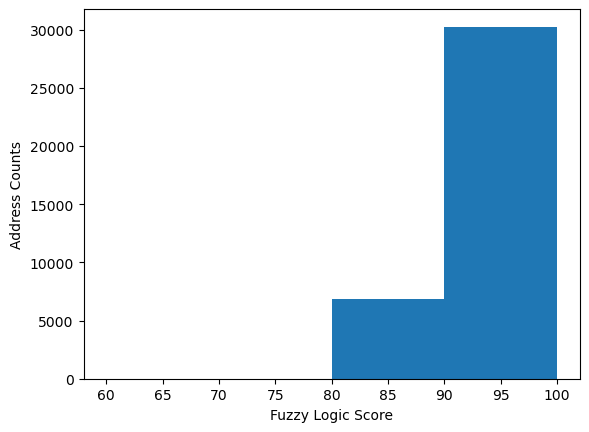

In [29]:
plt.hist(df_match_near["Match Score"], bins=np.arange(60,105,10))
plt.xlabel('Fuzzy Logic Score')
plt.ylabel('Address Counts')
plt.show()

In [30]:
df_sl["Customer-Owned Portion Service Line Material Classification"].unique()

array(['MU', 'GAL', 'PL', 'CU', 'OT'], dtype=object)

<Axes: xlabel='NBRHD'>

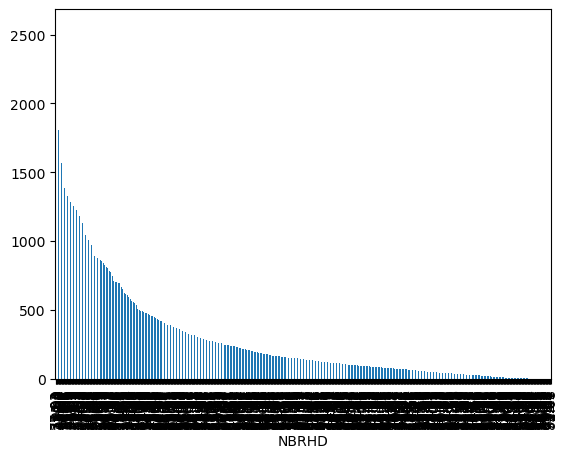

In [41]:
df_match_combined_filtered["NBRHD"].value_counts().plot(kind='bar')